In [ ]:
from low_rank_rnns.modules import *
import matplotlib
from low_rank_rnns import mante, ranktwo, clustering, helpers, mante_regressions, rankone
from sklearn.mixture import GaussianMixture
import seaborn as sns
from scipy import stats
import pandas as pd

In [40]:
matplotlib.rcParams['figure.figsize'] = (6, 5)
matplotlib.rcParams['font.size'] = 40
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.titlesize'] = 'medium'
matplotlib.rcParams['xtick.labelsize'] = 40
matplotlib.rcParams['ytick.labelsize'] = 40
matplotlib.rcParams['text.usetex'] = True

colors = ['seagreen', 'rebeccapurple']
col_ctxA = '#840045'
col_ctxB = '#ae8844'

In [41]:
def time_mapping(t):
    return t * mante.deltaT / 1000

# Loading CDM 2 populations network

In [42]:
hidden_size = 4096
noise_std = 5e-2
alpha = 0.2
mante.SCALE_CTX = 1
x_train, y_train, mask_train, x_val, y_val, mask_val = mante.generate_mante_data(1000, fraction_validation_trials=.2)
net = LowRankRNN(4, hidden_size, 1, noise_std, alpha, rank=1)
net.load_state_dict(torch.load(f'../models/mante_train_ctx_new_epoch2-4096.pt', map_location='cpu'))

In [43]:
mante.test_mante(net, x_val, y_val, mask_val)

(0.030637869611382484, 0.9900000095367432)

In [44]:
m = net.m[:,0].detach().numpy()
n = net.n[:,0].detach().numpy()
wi1 = net.wi[0].detach().numpy()
wi2 = net.wi[1].detach().numpy()
wi_ctx1 = net.wi[2].detach().numpy()
wi_ctx2 = net.wi[3].detach().numpy()
wo = net.wo[:,0].detach().numpy()
vecs = clustering.make_vecs(net)

# Positivity adjustments
n = -n
m = -m

In [45]:
n_pops = 2
vecs = clustering.make_vecs(net)
z, model = clustering.gmm_fit(vecs, n_pops, algo='bayes', n_init=50, random_state=2020)

z = 1 - z   # inverting population labels for presentation purposes

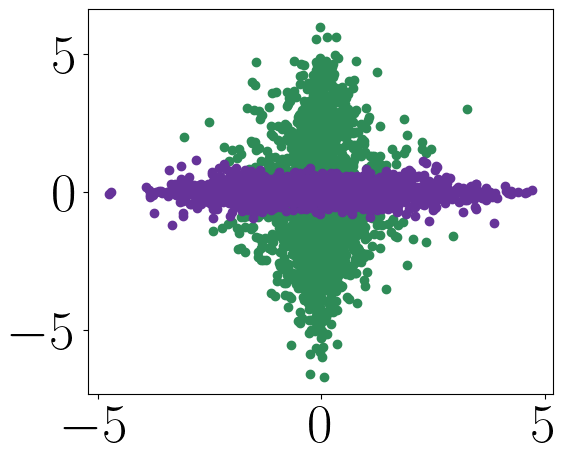

In [46]:
for i in range(n_pops):
    plt.scatter(wi_ctx1[z==i], wi_ctx2[z==i], c=colors[i])

# Panel a

In [47]:
input_trial, y_train, mask_train = mante.generate_mante_data(1, coh_color_spec=0, coh_motion_spec=0, context_spec=0,
                                                            fraction_validation_trials=0.)

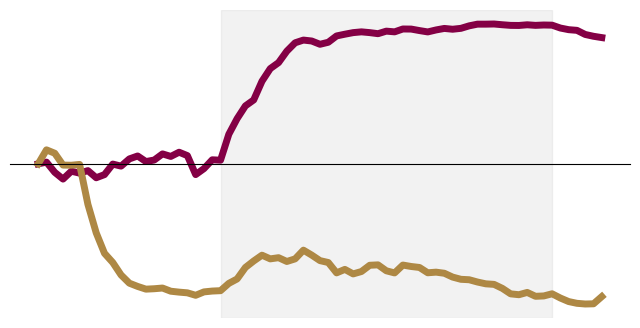

In [48]:
neuron = 2902

col_stim_period = 'silver'
alpha_periods = .2
#plot_width = 6

coh1 = -4
coh2 = +2

x1 = mante.generate_specified_input(coh1, coh2, 1, 1)
outp1, trajectories1 = net.forward(x1, return_dynamics=True)
trajectories1 = trajectories1.detach().numpy().squeeze()
rates1 = np.tanh(trajectories1)

x1 = mante.generate_specified_input(coh1, coh2, 2, 1)
outp1, trajectories1 = net.forward(x1, return_dynamics=True)
trajectories1 = trajectories1.detach().numpy().squeeze()
rates2 = np.tanh(trajectories1)

rates = np.concatenate((rates1[:, neuron].reshape((-1, 1)), rates2[:, neuron].reshape((-1,1))), axis=1)

fig, ax = plt.subplots(figsize=(8,4))
tx = time_mapping(np.arange(0,len(rates[:,0])))

ax.plot(tx, -rates[:,0], lw=5, c=col_ctxA)
ax.plot(tx, -rates[:,1], lw=5, c=col_ctxB)
helpers.center_axes(ax)
ax.spines['left'].set_visible(False)

ax.axvspan(time_mapping(mante.stim_begin), time_mapping(mante.stim_end), color=col_stim_period, alpha=alpha_periods)


[ 0.  2.  4.  6.  8. 10.]


Text(0, 0.5, 'rate response')

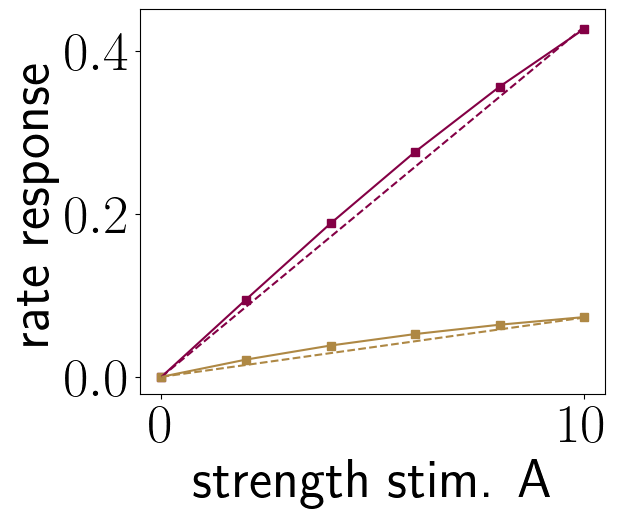

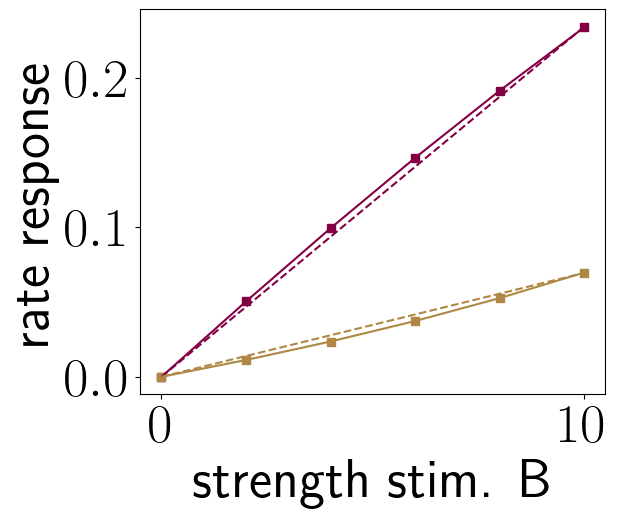

In [49]:
neuron = 2902
epoch_start = mante.stim_begin
epoch_end = mante.stim_begin + 5
net.noise_std = 0
col_sel1, mot_sel1, col_sel2, mot_sel2 = mante_regressions.plot_tuning_curves(net, neuron, epoch_start, epoch_end, add_linreg=True, col1=col_ctxA, col2=col_ctxB)

plt.figure(0);plt.xlabel('strength stim. A');plt.ylabel('rate response')
# plt.savefig('tuning_curves_A_Trained2pops.eps', bbox_inches='tight')


plt.figure(1);plt.xlabel('strength stim. B');plt.ylabel('rate response')
# plt.savefig('tuning_curves_B_Trained2pops.eps', bbox_inches='tight')

# Panel B

(2, 1) (2, 4096)
(4096, 1)
torch.Size([121, 68, 4])
(121, 2)
torch.Size([121, 68, 4])
(121, 2)
-0.04989715852453706 0.0014753963895703058 -0.8354609965800505 0.0 0.0005129590864539939


Text(0, 0.5, '$\\Delta_{ctx} \\beta^{B}$')

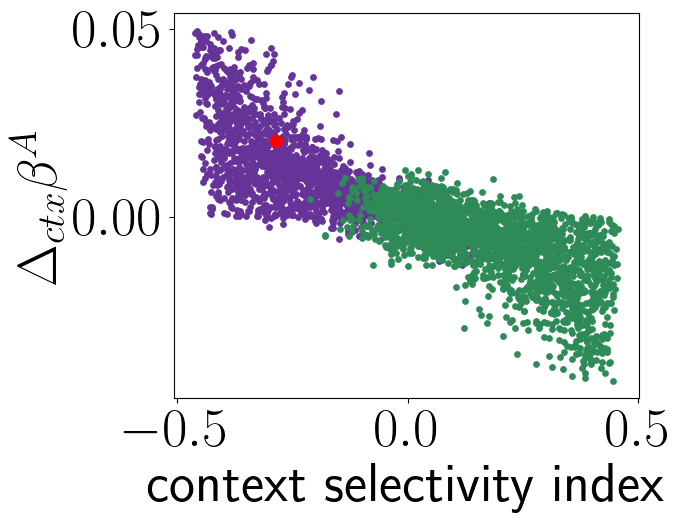

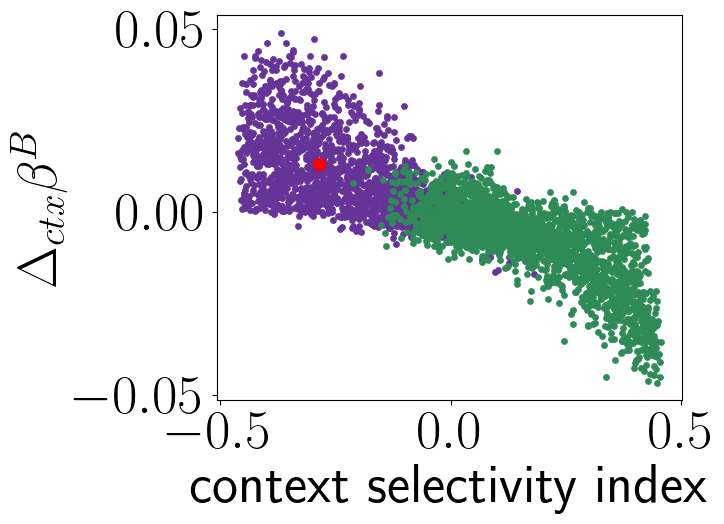

In [50]:
r_ctx_single = mante_regressions.compute_single_ctx_regressors(net)

regs = mante_regressions.compute_sensory_regressors(net, mante.stim_begin, mante.stim_begin+5)

r_sensory_ctxt1 = regs[0]
r_sensory_ctxt2 = regs[1]

ind_plot = np.where(z==0)
size_dots = 15
plt.figure(1)
plt.scatter(r_ctx_single[ind_plot,0],np.abs(r_sensory_ctxt1[ind_plot,0])-np.abs(r_sensory_ctxt2[ind_plot,0]),color='rebeccapurple',s=size_dots)

plt.xlabel('context selectivity index')
plt.ylabel(r'$\Delta_{ctx} \beta^{A}$')

vec1 = r_ctx_single[:,0]
vec2 = np.abs(r_sensory_ctxt1[:,0])-np.abs(r_sensory_ctxt2[:,0])

slope, intercept, r_value, p_value, std_err = stats.linregress(vec1, vec2)
print(slope,intercept,r_value,p_value,std_err)

plt.figure(2);plt.scatter(r_ctx_single[ind_plot,0],np.abs(r_sensory_ctxt1[ind_plot,1])-np.abs(r_sensory_ctxt2[ind_plot,1]),color='rebeccapurple',s=size_dots)
plt.xlabel('context selectivity index')
plt.ylabel(r'$\Delta_{ctx} \beta^{B}$')



ind_plot = np.where(z==1)

plt.figure(1);plt.scatter(r_ctx_single[ind_plot,0],np.abs(r_sensory_ctxt1[ind_plot,0])-np.abs(r_sensory_ctxt2[ind_plot,0]),color='seagreen',s=size_dots)
plt.figure(1);plt.scatter(r_ctx_single[neuron,0],np.abs(r_sensory_ctxt1[neuron,0])-np.abs(r_sensory_ctxt2[neuron,0]),color='red', s=75)


plt.xlabel('context selectivity index')
plt.ylabel(r'$\Delta_{ctx} \beta^{A}$')


plt.figure(2);plt.scatter(r_ctx_single[ind_plot,0],np.abs(r_sensory_ctxt1[ind_plot,1])-np.abs(r_sensory_ctxt2[ind_plot,1]),color='seagreen',s=size_dots)
plt.figure(2);plt.scatter(r_ctx_single[neuron,0],np.abs(r_sensory_ctxt1[neuron,1])-np.abs(r_sensory_ctxt2[neuron,1]),color='red', s=75)


plt.xlabel('context selectivity index')
plt.ylabel(r'$\Delta_{ctx} \beta^{B}$')


# Panel C

(8, 4)


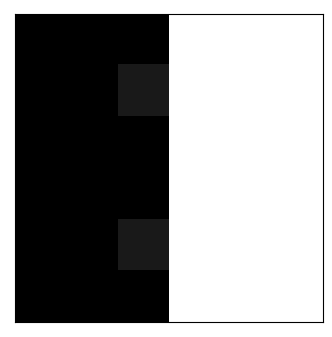

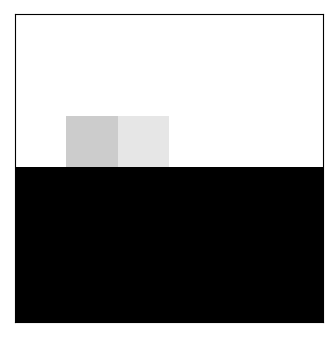

In [60]:
# Baseline performance

axes = mante.psychometric_matrices(net, figsize=(4,4))

In [61]:
fraction_correct_context_1 = []
fraction_correct_context_2 = []

Text(0.5, 1.0, 'clus. pop2 ; Ctx B')

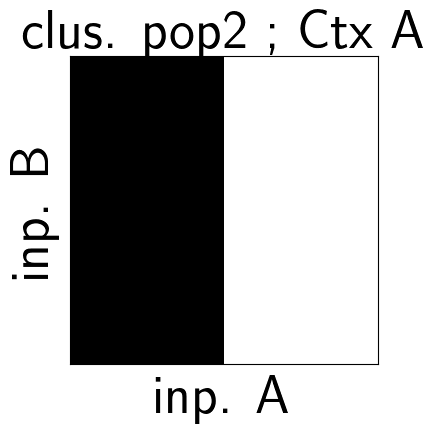

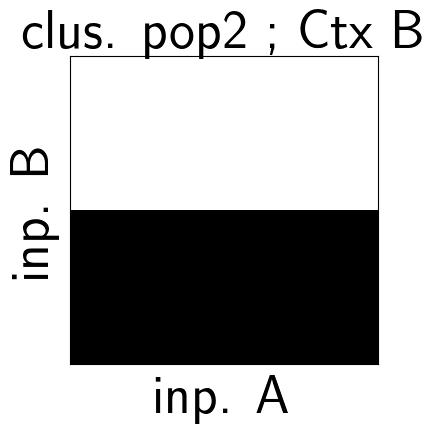

In [62]:
# Inactivating random neurons

frac = 0.25
figs = mante.inactivating_pop_matrices(net, frac, np.ones(hidden_size), figsize=(4, 4))
plt.figure(figs[0].number)
plt.xlabel('inp. A')
plt.ylabel('inp. B')
plt.title('clus. pop2 ; Ctx A')
#     plt.savefig('figures/ablate_mante_random_frac'+str(100*frac)+'_ctx1.eps', bbox_inches='tight')
plt.figure(figs[1].number)
plt.xlabel('inp. A')
plt.ylabel('inp. B')
plt.title('clus. pop2 ; Ctx B')
#     plt.savefig('figures/ablate_mante_random_frac'+str(100*frac)+'_ctx2.eps', bbox_inches='tight')

In [63]:
fraction_correct_context_1.append(np.mean(figs[2]))
fraction_correct_context_2.append(np.mean(figs[3]))

accs_all_1 = figs[2]
accs_all_2 = figs[3]

In [64]:
# Defining two groups of neurons based on their context regressor

number_ablated_neurons = int(frac * hidden_size)

index_ctx1_single_reg = np.where(r_ctx_single[:,0]>.1)[0]
index_ctx2_single_reg = np.where(r_ctx_single[:,0]<-.1)[0]

In [65]:
index_ctx1_single_reg[:10]

array([ 0,  7, 15, 26, 27, 33, 36, 39, 43, 45])

Text(0.5, 1.0, 'clus. pop2 ; Ctx B')

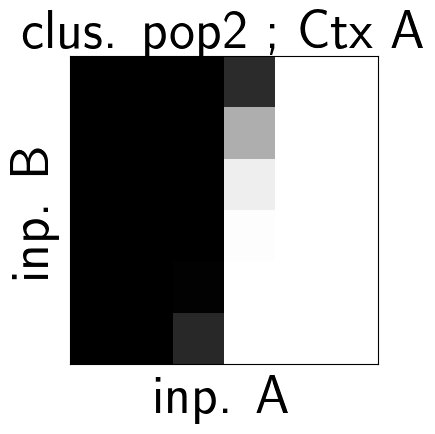

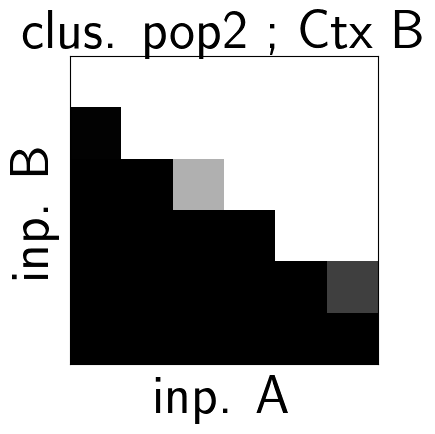

In [66]:
# Inactivating ctx A selective neurons

z_1reg = np.zeros(z.shape)
z_1reg[index_ctx1_single_reg] = 1
z_1reg[index_ctx2_single_reg] = 0

frac_tmp = number_ablated_neurons / len(index_ctx1_single_reg)
figs = mante.inactivating_pop_matrices(net, frac_tmp, z_1reg, figsize=(4, 4))
plt.figure(figs[0].number)
plt.xlabel('inp. A')
plt.ylabel('inp. B')
plt.title('clus. pop2 ; Ctx A')
# plt.savefig('figures/ablate_mante_1ctxRegRandom_pop'+str(pop)+'_frac'+str(int(100*frac))+'_ctx1.eps', bbox_inches='tight')
plt.figure(figs[1].number)
plt.xlabel('inp. A')
plt.ylabel('inp. B')
plt.title('clus. pop2 ; Ctx B')
# plt.savefig('figures/ablate_mante_1ctxRegRandom_pop'+str(pop)+'_frac'+str(int(100*frac))+'_ctx2.eps', bbox_inches='tight')
    
    
    

In [67]:
fraction_correct_context_1.append(np.mean(figs[2]))
fraction_correct_context_2.append(np.mean(figs[3]))

accs_A_1 = figs[2]
accs_A_2 = figs[3]

print(fraction_correct_context_1, fraction_correct_context_2)


[1.0, 0.9994444444775581] [1.0, 0.6916666670805879]


Text(0.5, 1.0, 'clus. pop2 ; Ctx B')

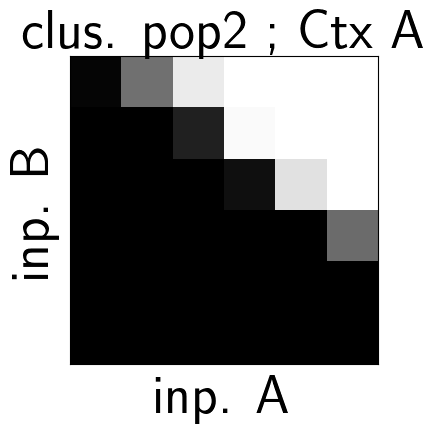

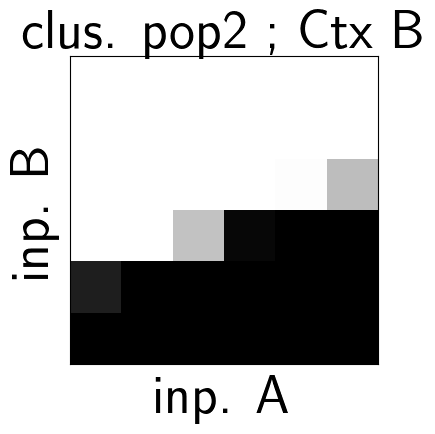

In [68]:
# Inactivating ctx B selective neurons

frac_tmp = number_ablated_neurons / len(index_ctx2_single_reg)

figs = mante.inactivating_pop_matrices(net, frac_tmp, 1-z_1reg, figsize=(4, 4))
plt.figure(figs[0].number)
plt.xlabel('inp. A')
plt.ylabel('inp. B')
plt.title('clus. pop2 ; Ctx A')
# plt.savefig('figures/ablate_mante_1ctxRegRandom_pop'+str(pop)+'_frac'+str(int(100*frac))+'_ctx1.eps', bbox_inches='tight')
plt.figure(figs[1].number)
plt.xlabel('inp. A')
plt.ylabel('inp. B')
plt.title('clus. pop2 ; Ctx B')
# plt.savefig('figures/ablate_mante_1ctxRegRandom_pop'+str(pop)+'_frac'+str(int(100*frac))+'_ctx2.eps', bbox_inches='tight')

In [69]:
fraction_correct_context_1.append(np.mean(figs[2]))
fraction_correct_context_2.append(np.mean(figs[3]))

accs_B_1 = figs[2]
accs_B_2 = figs[3]

print(np.mean(figs[2]), np.mean(figs[3]))


0.4394444446596834 0.9983333334326744


# Panel D

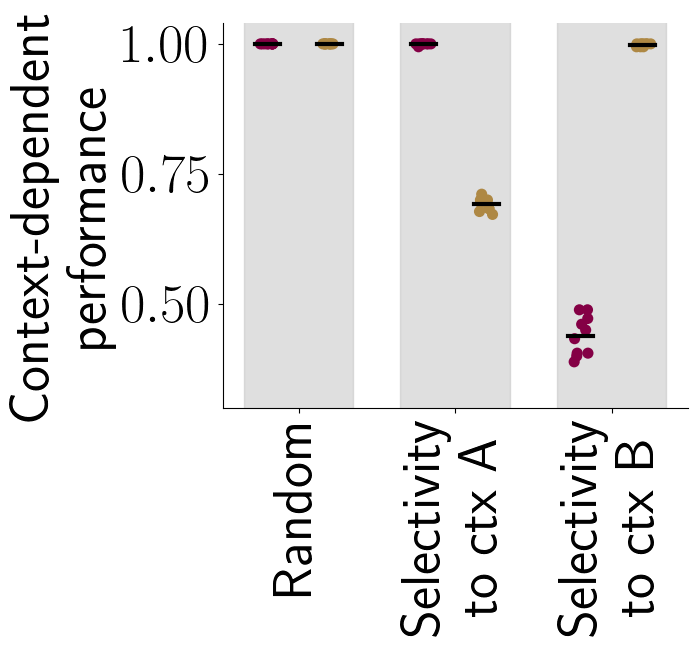

In [70]:
n_samples = 10

all_accuracies = [accs_all_1, accs_all_2, accs_A_1, accs_A_2, accs_B_1, accs_B_2]
tmp_df = pd.DataFrame({'perf': np.concatenate(all_accuracies),
                       'experiment': np.array(['random']*(2*n_samples) + ['A']*(2*n_samples) + ['B']*(2*n_samples)),
                       'ctx': np.array((['A']*n_samples + ['B']*n_samples) * 3)})

fig, ax = plt.subplots()
sns.stripplot(data=tmp_df, x='experiment', y='perf', hue='ctx', dodge=True, ax=ax, s=8, palette=[col_ctxA, col_ctxB])
ax.set_ylabel('Context-dependent\nperformance')
ax.legend([], [], frameon=False)
ax.set_xlabel('')
ax.set_xticklabels(['Random', 'Selectivity\nto ctx A', 'Selectivity\nto ctx B'], rotation=90)
ax.set_ylim(.3, 1.04)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i in range(3):
    ax.fill_betweenx([0, 1.1], i-.35, i+.35, color='silver', alpha=.5)
    
    mean_perf = np.mean(all_accuracies[i*2])
    plt.plot([i-.28, i-.12],[mean_perf, mean_perf], color='k', linewidth = 3, zorder=10)
    mean_perf = np.mean(all_accuracies[i*2 + 1])
    plt.plot([i+.12, i+.28],[mean_perf, mean_perf], color='k', linewidth = 3, zorder=10)

# Panel E

In [83]:
hidden_size = 4096
noise_std = 5e-2
alpha = 0.2
x_train, y_train, mask_train, x_val, y_val, mask_val = mante.generate_mante_data(1000, fraction_validation_trials=.2)
net = OptimizedLowRankRNN(4, hidden_size, 1, noise_std, alpha, rank=1, train_wi=False, train_si=False, train_wrec=False, train_wo=True, train_so=False)
net.load_state_dict(torch.load(f'../models/mante_rank1_all-{hidden_size}-6.pt', map_location='cpu'))

# with torch.no_grad():
#     net.wo *= 5*net.hidden_size

In [84]:
mante.test_mante(net, x_val, y_val, mask_val)

(0.061269812285900116, 1.0)

In [85]:
m = net.m[:,0].detach().numpy()
n = net.n[:,0].detach().numpy()
wi1 = net.wi[0].detach().numpy()
wi2 = net.wi[1].detach().numpy()
wi_ctx1 = net.wi[2].detach().numpy()
wi_ctx2 = net.wi[3].detach().numpy()
wo = net.wo[:,0].detach().numpy()
vecs = clustering.make_vecs(net)

In [86]:
n_pops = 4
vecs = clustering.make_vecs(net)
z, model = clustering.gmm_fit(vecs, n_pops, algo='bayes', n_init=50, random_state=2020)
colors = ['gray', 'rebeccapurple', 'goldenrod', 'seagreen']

In [87]:
r_ctx_single = mante_regressions.compute_single_ctx_regressors(net)

(2, 1) (2, 4096)
(4096, 1)


(12.0, 5.0)


Text(0.5, 1.0, 'clus. pop1 ; Ctx B')

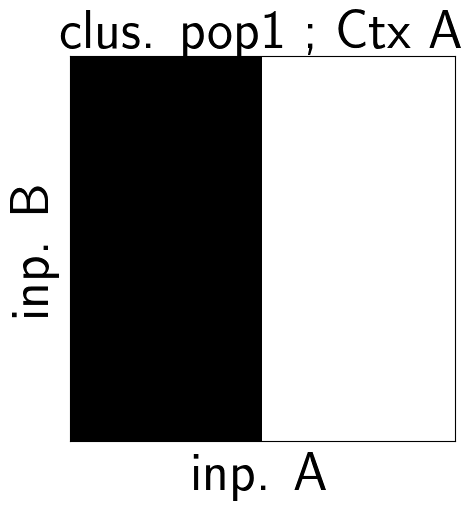

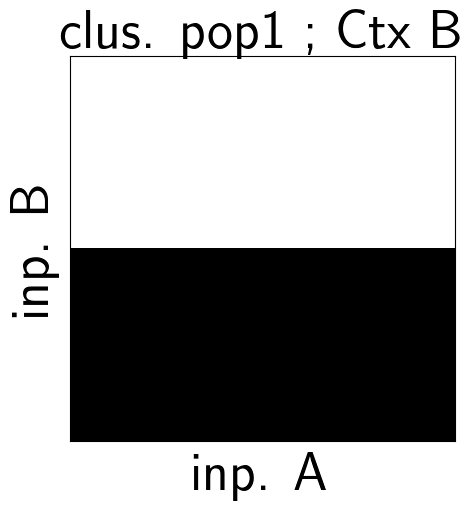

In [88]:
mante.psychometric_matrices(net)
plt.figure(figs[0].number)
plt.xlabel('inp. A')
plt.ylabel('inp. B')
plt.title('clus. pop1 ; Ctx A')
#plt.savefig('figures/net3pops_baseline_ctx1.eps', bbox_inches='tight')
plt.figure(figs[1].number)
plt.xlabel('inp. A')
plt.ylabel('inp. B')
plt.title('clus. pop1 ; Ctx B')
#plt.savefig('figures/net3pops_baseline_ctx2.eps', bbox_inches='tight')

In [89]:
fraction_correct_context_1 = []
fraction_correct_context_2 = []

Text(0.5, 1.0, 'clus. pop2 ; Ctx B')

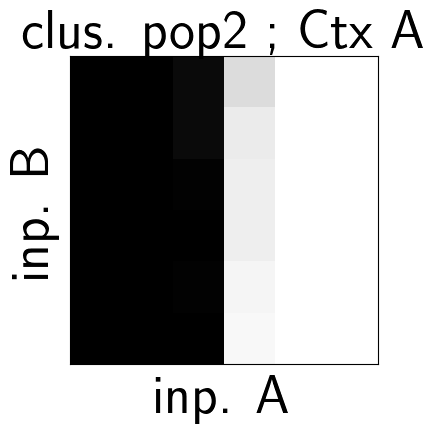

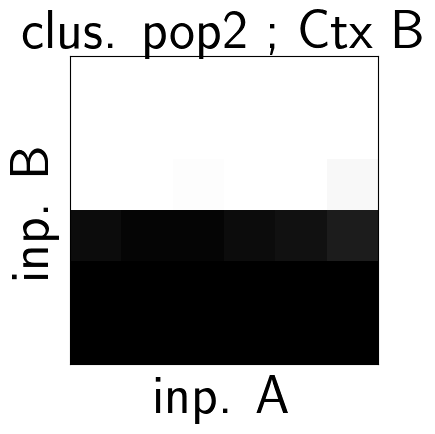

In [90]:
# Inactivating random neurons

frac = 0.25
figs = mante.inactivating_pop_matrices(net, frac, np.ones(hidden_size), figsize=(4, 4))
plt.figure(figs[0].number)
plt.xlabel('inp. A')
plt.ylabel('inp. B')
plt.title('clus. pop2 ; Ctx A')
#     plt.savefig('figures/net3pops_ablate_random_ctx1.eps', bbox_inches='tight')
plt.figure(figs[1].number)
plt.xlabel('inp. A')
plt.ylabel('inp. B')
plt.title('clus. pop2 ; Ctx B')
#     plt.savefig('figures/net3pops_ablate_random_ctx2.eps', bbox_inches='tight')

In [91]:
fraction_correct_context_1.append(np.mean(figs[2]))
fraction_correct_context_2.append(np.mean(figs[3]))

accs_all_1 = figs[2]
accs_all_2 = figs[3]

In [92]:
# Defining two groups of neurons based on their context regressor
frac = 0.25
number_ablated_neurons = int(frac * hidden_size)

index_ctx1_single_reg = np.where(r_ctx_single[:,0]>0)[0]
index_ctx2_single_reg = np.where(r_ctx_single[:,0]<0)[0]

In [93]:
z_1reg = np.zeros(z.shape)
z_1reg[index_ctx1_single_reg] = 1
z_1reg[index_ctx2_single_reg] = 0


Text(0.5, 1.0, 'clus. pop2 ; Ctx B')

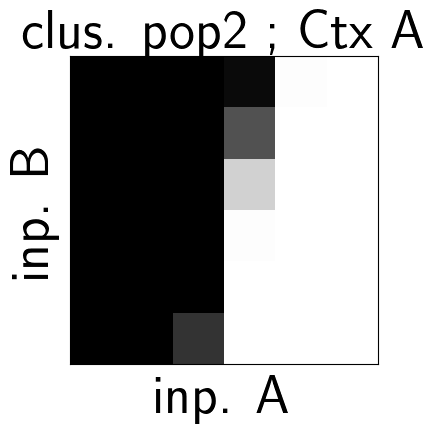

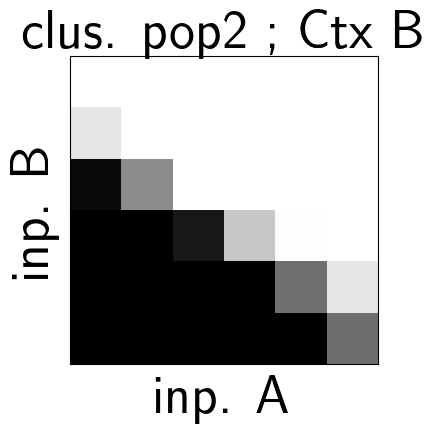

In [94]:
# Inactivating ctx A selective neurons

z_1reg = np.zeros(z.shape)
z_1reg[index_ctx1_single_reg] = 1
z_1reg[index_ctx2_single_reg] = 0

frac_tmp = number_ablated_neurons / len(index_ctx1_single_reg)
figs = mante.inactivating_pop_matrices(net, frac_tmp, z_1reg, figsize=(4, 4))
plt.figure(figs[0].number)
plt.xlabel('inp. A')
plt.ylabel('inp. B')
plt.title('clus. pop2 ; Ctx A')
# plt.savefig('figures/net3pops_ablate_1_ctx1.eps', bbox_inches='tight')
plt.figure(figs[1].number)
plt.xlabel('inp. A')
plt.ylabel('inp. B')
plt.title('clus. pop2 ; Ctx B')
# plt.savefig('figures/net3pops_ablate_1_ctx2.eps', bbox_inches='tight')
    
    
    

In [95]:
fraction_correct_context_1.append(np.mean(figs[2]))
fraction_correct_context_2.append(np.mean(figs[3]))

accs_A_1 = figs[2]
accs_A_2 = figs[3]

print(fraction_correct_context_1, fraction_correct_context_2)


[0.9872222226940923, 0.9994444444775581] [0.9866666667163372, 0.6638888886819283]


Text(0.5, 1.0, 'clus. pop2 ; Ctx B')

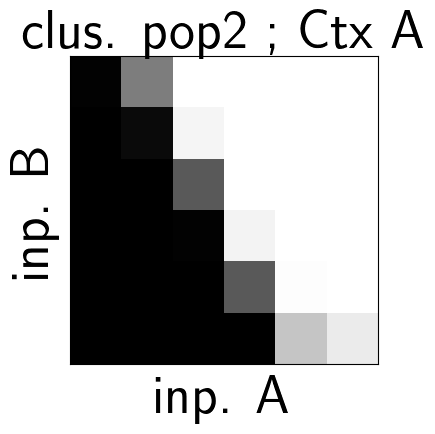

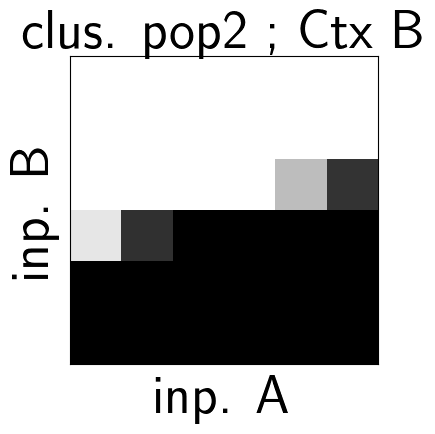

In [96]:
# Inactivating ctx B selective neurons

frac_tmp = number_ablated_neurons / len(index_ctx2_single_reg)

figs = mante.inactivating_pop_matrices(net, frac_tmp, 1-z_1reg, figsize=(4, 4))
plt.figure(figs[0].number)
plt.xlabel('inp. A')
plt.ylabel('inp. B')
plt.title('clus. pop2 ; Ctx A')
# plt.savefig('figures/net3pops_ablate_mante_2_ctx1.eps', bbox_inches='tight')
plt.figure(figs[1].number)
plt.xlabel('inp. A')
plt.ylabel('inp. B')
plt.title('clus. pop2 ; Ctx B')
# plt.savefig('figures/net3pops_ablate_mante_2_ctx2.eps', bbox_inches='tight')

In [97]:
fraction_correct_context_1.append(np.mean(figs[2]))
fraction_correct_context_2.append(np.mean(figs[3]))

accs_B_1 = figs[2]
accs_B_2 = figs[3]

print(np.mean(figs[2]), np.mean(figs[3]))


0.729444444593456 1.0


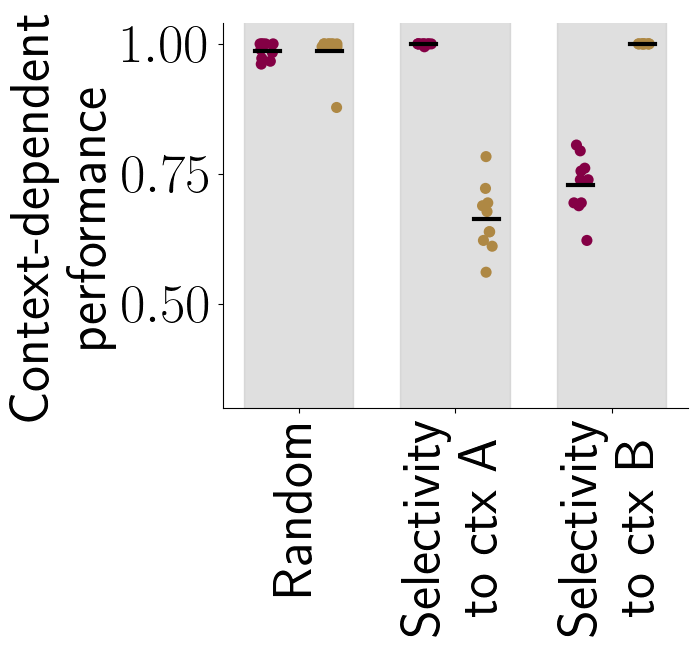

In [98]:
n_samples = 10

all_accuracies = [accs_all_1, accs_all_2, accs_A_1, accs_A_2, accs_B_1, accs_B_2]
tmp_df = pd.DataFrame({'perf': np.concatenate(all_accuracies),
                       'experiment': np.array(['random']*(2*n_samples) + ['A']*(2*n_samples) + ['B']*(2*n_samples)),
                       'ctx': np.array((['A']*n_samples + ['B']*n_samples) * 3)})

fig, ax = plt.subplots()
sns.stripplot(data=tmp_df, x='experiment', y='perf', hue='ctx', dodge=True, ax=ax, s=8, palette=[col_ctxA, col_ctxB])
ax.set_ylabel('Context-dependent\nperformance')
ax.legend([], [], frameon=False)
ax.set_xlabel('')
ax.set_xticklabels(['Random', 'Selectivity\nto ctx A', 'Selectivity\nto ctx B'], rotation=90)
ax.set_ylim(.3, 1.04)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i in range(3):
    ax.fill_betweenx([0, 1.1], i-.35, i+.35, color='silver', alpha=.5)
    
    mean_perf = np.mean(all_accuracies[i*2])
    plt.plot([i-.28, i-.12],[mean_perf, mean_perf], color='k', linewidth = 3, zorder=10)
    mean_perf = np.mean(all_accuracies[i*2 + 1])
    plt.plot([i+.12, i+.28],[mean_perf, mean_perf], color='k', linewidth = 3, zorder=10)